In [4]:
from datascience import *
import numpy as np

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
baby = Table.read_table('baby.csv')

# Inference in Regression

## Regression: a Review

Earlier in the course, we developed the concepts of correlation and regression as ways to describe relations between quantitative variables. We will now see how these concepts can become powerful tools for inference, when used appropriately.

First, let us briefly review the main ideas of correlation and regression, along with code for calculations.

It is often convenient to measure variables in **standard units**. When you convert a value to standard units, you are measuring how many standard deviations above average the value is. 

The function `standard_units` takes an array as its argument and returns the array converted to standard units.

In [1]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

The **correlation** between two variables measures the degree to which a scatter plot of the two variables is clustered around a straight line. It has no units and is a number between -1 and 1. It is calculated as the average of the product of the two variables, when both variables are measured in standard units.

The function `correlation` takes three arguments – the name of a table and the labels of two columns of the table – and returns the correlation between the two columns.

In [19]:
def correlation(table, x, y):
    x_in_standard_units = standard_units(table.column(x))
    y_in_standard_units = standard_units(table.column(y))
    return np.mean(x_in_standard_units * y_in_standard_units)

Here is the scatter plot of birth weight (the *y*-variable) versus gestational days (the *x*-variable) of the babies in the table `baby`. The plot shows a positive association, and `correlation` returns a value of just over 0.4.

In [20]:
correlation(baby, 'Gestational Days', 'Birth Weight')

0.40754279338885108

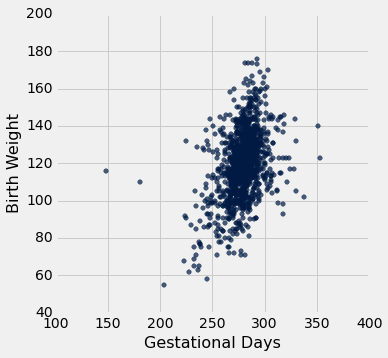

In [123]:
baby.scatter('Gestational Days', 'Birth Weight')

When `scatter` is called with the option `fit_line=True`, the regression line is drawn on the scatter plot.

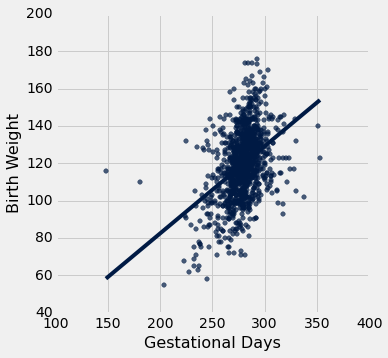

In [21]:
baby.scatter('Gestational Days', 'Birth Weight', fit_line=True)

The **regression line** is the best among all straight lines that could be used to estimate $y$ based on $x$, in the sense that it minimizes the mean squared error of estimation.

The **slope of the regression line** is given by:
$$
\mbox{slope} ~=~ r \times 
\frac{\mbox{SD of }y}{\mbox{SD of }x}
$$
where $r$ is the correlation.

The **intercept of the regression line** is given by
$$
\mbox{intercept} ~=~ \mbox{average of }y ~-~
\mbox{slope} \times \mbox{average of }x
$$

The functions `slope` and `intercept` calculate these two quantities. Each takes the same three arguments as `correlation`: the name of the table and the labels of columns $x$ and $y$, in that order.

In [22]:
def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

In [23]:
def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) -  a * np.mean(table.column(x))

We can now calculate the slope and the intercept of the regression line drawn above. The slope is about 0.47 ounces per gestational day.

In [24]:
slope(baby, 'Gestational Days', 'Birth Weight')

0.46655687694921522

The intercept is about -10.75 ounces.

In [25]:
intercept(baby, 'Gestational Days', 'Birth Weight')

-10.754138914450252

Thus the **equation of the regression line** for estimating birth weight based on gestational days is:
$$
\mbox{estimate of birth weight} ~=~
0.47 \times \mbox{gestational days} - 10.75
$$

The **fitted value** at a given value of $x$ is the estimate of $y$ based on that value of $x$. In other words, the fitted value at a given value of $x$ is the height of the regression line at that $x$.

The function `fitted_value` computes this height. Like the functions `correlation`, `slope`, and `intercept`, its arguments include the name of the table and the labels of the $x$ and $y$ columns. But it also requires a fourth argument, which is the value of $x$ at which the estimate will be made.

In [26]:
def fitted_value(table, x, y, given_x):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * given_x  + b

The fitted value at 300 gestational days is about 129.2 ounces. For a pregnancy that has length 300 gestational days, our estimate for the baby's weight is about 129.2 ounces.

In [83]:
fitted_value(baby, 'Gestational Days', 'Birth Weight', 300)

129.2129241703143

The function `fit` returns an array consisting of the fitted values at all of the values of $x$ in the table.

In [34]:
def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

As we know, the Table method `scatter` can be used to draw a scatter plot with a regression line through it. Here is another way, using `fit`. The function `scatter_fit` takes the same three arguments as `fit` and returns a scatter diagram along with the straight line of fitted values.

In [124]:
def scatter_fit(table, x, y):
    plots.scatter(table.column(x), table.column(y), s=15)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='darkblue')
    plots.xlabel(x)
    plots.ylabel(y)

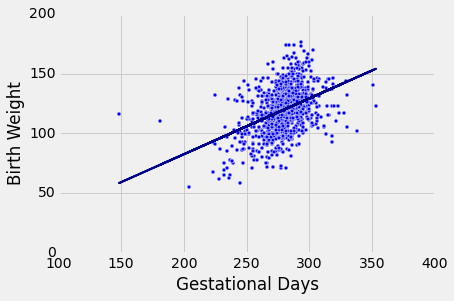

In [128]:
scatter_fit(baby, 'Gestational Days', 'Birth Weight')

# The next two lines just make the plot easier to read
plots.ylim([0, 200])
None

## Assumptions of randomness: a "regression model"
Thus far in this section, our analysis has been purely descriptive. But recall that the data are a random sample of all the births in a system of hospitals. What do the data say about the whole population of births? What could they say about a new birth at one of the hospitals?

Questions of inference may arise if we believe that a scatter plot reflects the underlying relation between the two variables being plotted but does not specify the relation completely. For example, a scatter plot of birth weight versus gestational days shows us the precise relation between the two variables in our sample; but we might wonder whether that relation holds true, or almost true, for all babies in the population from which the sample was drawn, or indeed among babies in general.

As always, inferential thinking begins with a careful examination of the assumptions about the data. Sets of assumptions are known as *models*. Sets of assumptions about randomness in roughly linear scatter plots are called *regression models*.

In brief, such models say that the underlying relation between the two variables is perfectly linear; this straight line is the *signal* that we would like to identify. However, we are not able to see the line clearly. What we see are points that are scattered around the line. In each of the points, the signal has been contaminated by *random noise*. Our inferential goal, therefore, is to separate the signal from the noise.

In greater detail, the regression model specifies that the points in the scatter plot are generated at random as follows.

- The relation between $x$ and $y$ is perfectly linear. We cannot see this "true line" but Tyche can. She is the Goddess of Chance.
- Tyche creates the scatter plot by taking points on the line and pushing them off the line vertically, either above or below, as follows:
    - For each $x$, Tyche finds the corresponding point on the true line, and then adds an error.
    - The errors are drawn at random with replacement from a population of errors that has a normal distribution with mean 0.
    - Tyche creates a point whose horizontal coordinate is $x$ and whose vertical coordinate is "the height of the true line at $x$, plus the error".
- Finally, Tyche erases the true line from the scatter, and shows us just the scatter plot of her points.

Based on this scatter plot, how should we estimate the true line? The best line that we can put through a scatter plot is the regression line. So the regression line is a natural estimate of the true line. 

The simulation below shows how close the regression line is to the true line. The first panel shows how Tyche generates the scatter plot from the true line; the second show the scatter plot that we see; the third shows the regression line through the plot; and the fourth shows both the regression line and the true line.

To run the simulation, call the function `draw_and_compare` with three arguments: the slope of the true line, the intercept of the true line, and the sample size.

Run the simulation a few times, with different values for the slope and intercept of the true line, and varying sample sizes. Because all the points are generated according to the model, you will see that the regression line is a good estimate of the true line if the sample size is moderately large.

In [129]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    eps = np.random.normal(0, 6, sample_size)
    y = (true_slope*x + true_int) + eps
    tyche = Table([x,y],['x','y'])

    plots.figure(figsize=(6, 16))
    plots.subplot(4, 1, 1)
    plots.scatter(tyche['x'], tyche['y'], s=15)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('What Tyche draws')

    plots.subplot(4, 1, 2)
    plots.scatter(tyche['x'],tyche['y'], s=15)
    plots.title('What we get to see')

    plots.subplot(4, 1, 3)
    scatter_fit(tyche, 'x', 'y')
    plots.xlabel("")
    plots.ylabel("")
    plots.title('Regression line: our estimate of true line')

    plots.subplot(4, 1, 4)
    scatter_fit(tyche, 'x', 'y')
    xlims = np.array([np.min(tyche['x']), np.max(tyche['x'])])
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression line and true line")

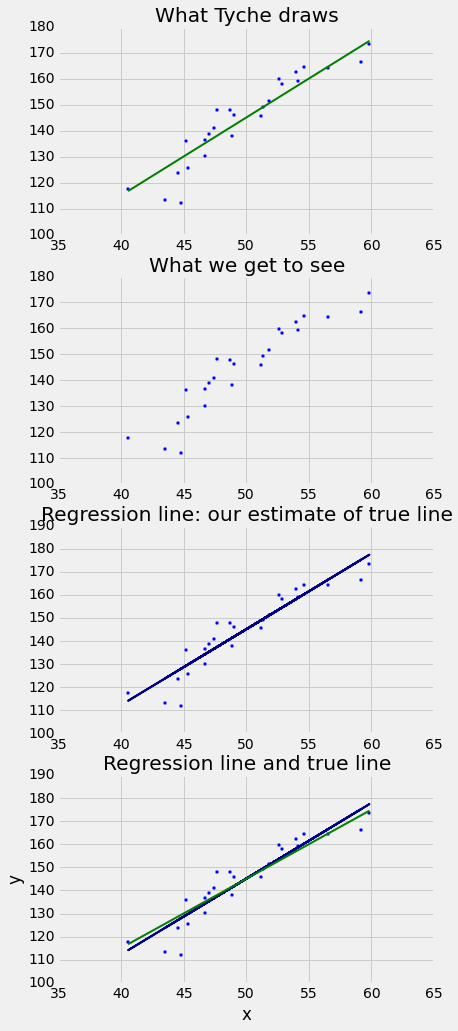

In [130]:
# Tyche's true line,
# the points she creates,
# and our estimate of the true line.
# Arguments: true slope, true intercept, number of points

draw_and_compare(3, -5, 25)

## Prediction using Regression
In reality, of course, we are not Tyche, and we will never see the true line. What the simulation shows that if the regression model looks plausible, and if we have a large sample, then the regression line is a good approximation to the true line.

The scatter diagram of birth weights versus gestational days looks roughly linear. Let us assume that the regression model holds. Suppose now that at the hospital there is a new baby who has 300 gestational days. We can use the regression line to predict the birth weight of this baby. 

As we saw earlier, the fitted value at 300 gestational days was about 129.2 ounces. That is our prediction for the birth weight of the new baby.

In [84]:
fit_300 = fitted_value(baby, 'Gestational Days', 'Birth Weight', 300)
fit_300

129.2129241703143

The figure below shows where the prediction lies on the regression line. The red line is at $x = 300$.

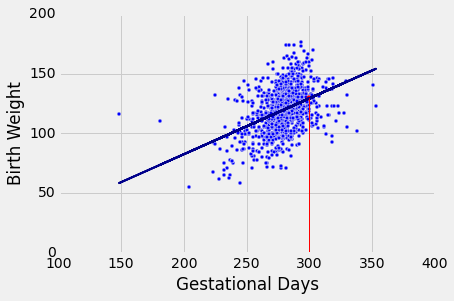

In [131]:
scatter_fit(baby, 'Gestational Days', 'Birth Weight')
plots.scatter(300, fit_300, color='red', s=20)
plots.plot([300,300], [0, fit_300], color='red', lw=1)
plots.ylim([0, 200])
None

## The Variability of the Prediction

We have developed a method for predicting a new baby's birthweight based on the number of gestational days. But as data scientists, we know that the sample might have been different. Had the sample been different, the regression line would have been different too, and so would our prediction. To see how good our prediction is, we must get a sense of how variable the prediction can be.

One way to do this would be by generating new random samples of points and making a prediction based on each new sample. To generate new samples, we can **bootstrap the scatter plot**.

Specifically, we can simulate new samples by random sampling with replacement from the original scatter plot, as many times as there are points in the scatter.

Here is the original scatter diagram from the sample, and four replications of the bootstrap resampling procedure. Notice how the resampled scatter plots are in general a little more sparse than the original. That is because some of the original point do not get selected in the samples.

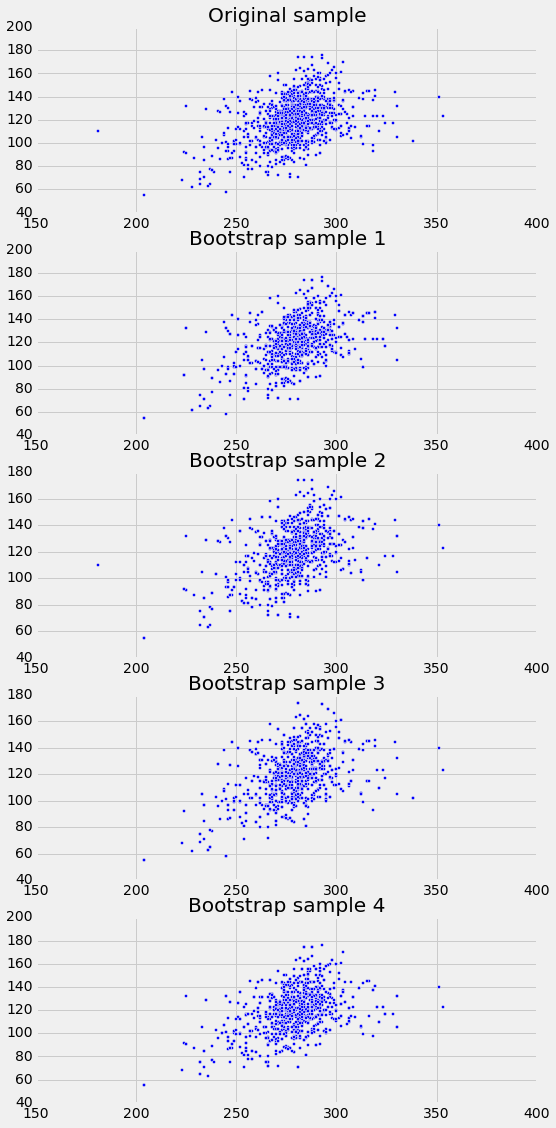

In [132]:
plots.figure(figsize=(8, 18))
plots.subplot(5, 1, 1)
plots.scatter(baby[1], baby[0], s=10)
plots.xlim([150, 400])
plots.title('Original sample')

for i in np.arange(1, 5, 1):
    plots.subplot(5,1,i+1)
    rep = baby.sample(with_replacement=True)
    plots.scatter(rep[1], rep[0], s=10)
    plots.xlim([150, 400])
    plots.title('Bootstrap sample '+str(i))

The next step is to fit the regression line to the scatter plot in each replication, and make a prediction based on each line. The figure below shows 10 such lines, and the corresponding predicted birth weight at 300 gestational days.

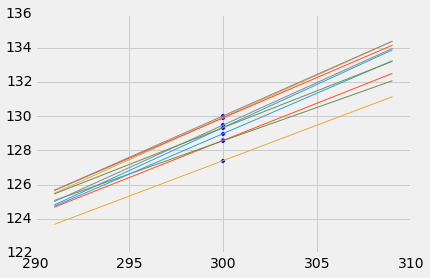

In [133]:
x = 300

lines = Table(['slope','intercept'])
for i in range(10):
    rep = baby.sample(with_replacement=True)
    a = slope(rep, 'Gestational Days', 'Birth Weight')
    b = intercept(rep, 'Gestational Days', 'Birth Weight')
    lines.append([a, b])

lines['prediction at x='+str(x)] = lines.column('slope')*x + lines.column('intercept')

xlims = np.array([291, 309])
left = xlims[0]*lines[0] + lines[1]
right = xlims[1]*lines[0] + lines[1]
fit_x = x*lines['slope'] + lines['intercept']

for i in range(10):
    plots.plot(xlims, np.array([left[i], right[i]]), lw=1)
    plots.scatter(x, fit_x[i], s=20)

The predictions vary from one line to the next. The table below shows the slope and intercept of each of the 10 lines, along with the prediction. 

In [134]:
lines

slope,intercept,prediction at x=300
0.504797,-22.095,129.344
0.435656,-2.10834,128.588
0.494682,-18.4687,129.936
0.389971,11.5772,128.568
0.498253,-19.9896,129.486
0.473853,-13.1711,128.985
0.472718,-11.9086,129.907
0.415704,2.69115,127.402
0.431619,-0.151519,129.334
0.485933,-15.754,130.026


## Bootstrap Prediction Interval

If we increase the number of repetitions of the resampling process, we can generate an empirical histogram of the predictions. This will allow us to create a prediction interval, using methods like those we used earlier to create bootstrap confidence intervals for numerical parameters.

In [135]:
# Bootstrap prediction at new_x
# table = `baby`, x = `Gestational Days`, y = `Birth Weight`

def bootstrap_interval(new_x, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter; 
    # get the regression prediction at new_x; 
    # augment the predictions list
    pred = []
    for i in range(repetitions):
        bootstrap_sample = baby.sample(with_replacement=True)
        prediction = fitted_value(bootstrap_sample, 'Gestational Days', 'Birth Weight', new_x)
        pred.append(prediction)
    
    # Prediction based on original sample
    original = fitted_value(baby, 'Gestational Days', 'Birth Weight', new_x)
    
    # Display results
    pred = Table().with_column('Prediction', pred)
    pred.hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    print('Height of regression line at x='+str(new_x)+':', original)
    print('Approximate 95%-confidence interval:')
    print((pred.percentile(2.5).rows[0][0], pred.percentile(97.5).rows[0][0]))

Height of regression line at x=300: 129.21292417
Approximate 95%-confidence interval:
(127.24807374472181, 131.40279064553931)


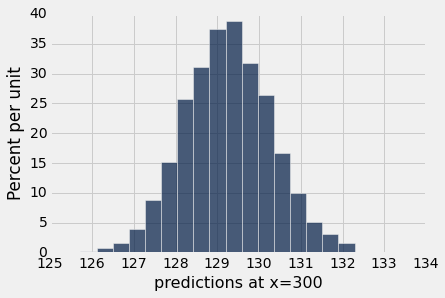

In [136]:
bootstrap_interval(300, 5000)

The figure above shows a bootstrap empirical histogram of the predicted birth weight of a baby at 300 gestational days, based on 5,000 repetitions of the bootstrap process. The empirical distribution is roughly normal. 

An approximate 95% prediction interval of scores has been constructed by taking the "middle 95%" of the predictions, that is, the interval from the 2.5th percentile to the 97.5th percentile of the predictions. The interval ranges from about 127 to about 131. The prediction based on the original sample was about 129, which is close to the center of the interval.

The figure below shows the histogram of 5,000 bootstrap predictions at 275 gestational days. The prediction based on the original sample is about 117.5 ounces, and the interval ranges from about 116.5 ounces to about 118.5 ounces. 

Notice that this interval is narrower than the interval at 300 gestational days. That is because 275 is nearer to the center of distributional days than 300 is. Typically, the lines are closer to each near the center. Therefore, the predictions are all closer to each other near the center.

Height of regression line at x=275: 117.549002247
Approximate 95%-confidence interval:
(116.50611840967797, 118.59274985045801)


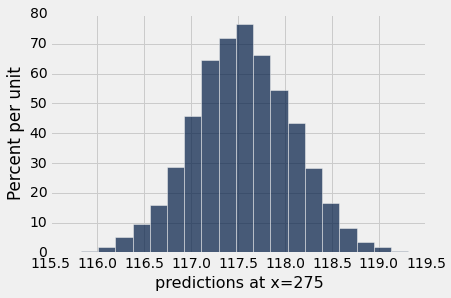

In [122]:
bootstrap_interval(275, 5000)